In [ ]:
# outcome probability model for fastballs

In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mysql.connector
import pybaseball
from sklearn.metrics import accuracy_score, confusion_matrix

In [19]:
# load in 2022 mlb season data

df = pd.read_csv(r'C:\Users\adam.bloebaum\.vscode\driveline\2022_MLB_Season.csv')

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"C:\Users\adam.bloebaum\.vscode\driveline\2023_MLB_Season.csv")

In [20]:
linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [21]:
xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_x_predictions.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_z_predictions.csv")
xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_spin_axis_predictions.csv")

In [22]:
print(xpfx_x.columns)
print(xpfx_z.columns)
print(xspin_axis.columns)

Index(['pitch_id_raw', 'pfx_x_cor', 'pfx_x_cor_predicted', 'pfx_x_cor_diff',
       'pfx_x_cor_diff_abs'],
      dtype='object')
Index(['pitch_id_raw', 'pfx_z', 'pfx_z_predicted', 'pfx_z_diff',
       'pfx_z_diff_abs'],
      dtype='object')
Index(['pitch_id_raw', 'spin_axis', 'spin_axis_predicted', 'spin_axis_diff',
       'spin_axis_diff_abs', 'arm_slot', 'height_ratio'],
      dtype='object')


In [23]:
# Clayton rerun with correct filename

xpfx_z.rename(columns={'pfx_z': 'pfx_z_cor'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_predicted': 'pfx_z_cor_predicted'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_diff': 'pfx_z_cor_diff'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_diff_abs': 'pfx_z_cor_diff_abs'}, inplace=True)

xspin_axis.rename(columns={'spin_axis': 'spin_axis_cor'}, inplace=True)

In [24]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs

df = df[df['pitch_type'].isin(['SL', 'ST', 'KC', 'SV', 'CU'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df['spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [25]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)


In [26]:

# select only fastballs

df_2023 = df_2023[df_2023['pitch_type'].isin(['SL', 'ST', 'KC', 'SV', 'CU'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df_2023['spin_axis'] = 360 - df['spin_axis']

# total movement column

df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column

df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [27]:
print(linear_weights)
print(df['description'].unique())
print(df['events'].unique())

    Unnamed: 0         description  linear_weight
0            0                ball       0.046350
1            1  caught_stealing_2b      -0.246377
2            2              double       0.753249
3            3         double_play      -0.773110
4            4           field_out      -0.217943
5            5                foul      -0.037243
6            6            home_run       1.368162
7            7              single       0.467429
8            8              strike      -0.052630
9            9           strikeout      -0.215231
10          10              triple       1.097815
11          11                walk       0.236323
['called_strike' 'swinging_strike' 'hit_into_play' 'ball' 'blocked_ball'
 'foul' 'hit_by_pitch' 'swinging_strike_blocked' 'foul_tip' 'foul_bunt'
 'missed_bunt' 'bunt_foul_tip']
[nan 'field_out' 'strikeout' 'single' 'home_run' 'double' 'walk'
 'hit_by_pitch' 'force_out' 'triple' 'sac_bunt' 'fielders_choice_out'
 'grounded_into_double_play' 'sac_fly_

In [28]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    #'hit_into_play': 'hit_into_play',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [29]:
def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# Apply the function to each row
df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [30]:
print(df['outcome'].unique())
print(df_2023['outcome'].unique())
print(df.shape)
print(df_2023.shape)

['strike' 'field_out' 'ball' 'strikeout' 'single' 'home_run' 'double'
 'foul' 'walk' 'triple' nan 'double_play']
['foul' 'ball' 'strike' 'field_out' 'single' 'strikeout' 'home_run'
 'double' 'walk' 'double_play' nan 'triple']
(226542, 98)
(226792, 98)


In [31]:
df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [32]:
print(df['outcome'].unique())
print(df_2023['outcome'].unique())
print(df.shape)
print(df_2023.shape)

['strike' 'field_out' 'ball' 'strikeout' 'single' 'home_run' 'double'
 'foul' 'walk' 'triple' 'double_play']
['foul' 'ball' 'strike' 'field_out' 'single' 'strikeout' 'home_run'
 'double' 'walk' 'double_play' 'triple']
(226103, 98)
(226351, 98)


In [33]:
outcome_encoder = LabelEncoder()

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [34]:
print(df['outcome'].unique())
print(df_2023['outcome'].unique())
print(df.shape)
print(df_2023.shape)

[ 7  3  0  8  6  5  1  4 10  9  2]
[ 4  0  7  3  6  8  5  1 10  2  9]
(226103, 98)
(226351, 98)


In [35]:
# Perform the left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')

# Perform the left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')

In [36]:
# feature selection and data splitting

features = ['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'release_extension', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio', 'pfx_x_cor', 'pfx_x_cor_predicted', 'pfx_x_cor_diff', 'pfx_x_cor_diff_abs', 'pfx_z_cor', 'pfx_z_cor_predicted', 'pfx_z_cor_diff_abs', 'spin_axis_cor', 'spin_axis_predicted', 'spin_axis_diff', 'spin_axis_diff_abs', 'arm_slot', 'height_ratio']

# copy and keep only features

df_2023_features = df_2023[features]

# create features and targets

X = df[features]
y = df['outcome']

# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
print(X_train.columns)

Index(['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'release_extension', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z',
       'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio', 'pfx_x_cor',
       'pfx_x_cor_predicted', 'pfx_x_cor_diff', 'pfx_x_cor_diff_abs',
       'pfx_z_cor', 'pfx_z_cor_predicted', 'pfx_z_cor_diff_abs',
       'spin_axis_cor', 'spin_axis_predicted', 'spin_axis_diff',
       'spin_axis_diff_abs', 'arm_slot', 'height_ratio'],
      dtype='object')


In [38]:
# set up model

model = xgb.XGBClassifier(objective='multi:softmax', num_class=11, eval_metric='mlogloss', use_label_encoder=False)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=11, num_parallel_tree=None, objective='multi:softmax', ...)

In [39]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.3577762543950819
Confusion Matrix:
[[15271     0     0    18    65     0     4   838    36     0     2]
 [  458     0     0     0     0     0     1    36     0     0     0]
 [  187     0     0     1     1     0     0     9     0     0     0]
 [ 4367     0     0     1    21     0     0   300    10     0     0]
 [ 6366     0     0     6    25     0     1   470     7     0     0]
 [  291     0     0     0     0     0     0    27     1     0     0]
 [ 1281     0     0     1    11     0     0    88     2     0     0]
 [ 9924     0     0    10    44     0     1   868    13     0     0]
 [ 3183     0     0     7    20     0     0   136    14     0     1]
 [   44     0     0     0     0     0     0     2     0     0     0]
 [  700     0     0     0     1     0     0    48     2     0     0]]


<Figure size 1000x5000 with 0 Axes>

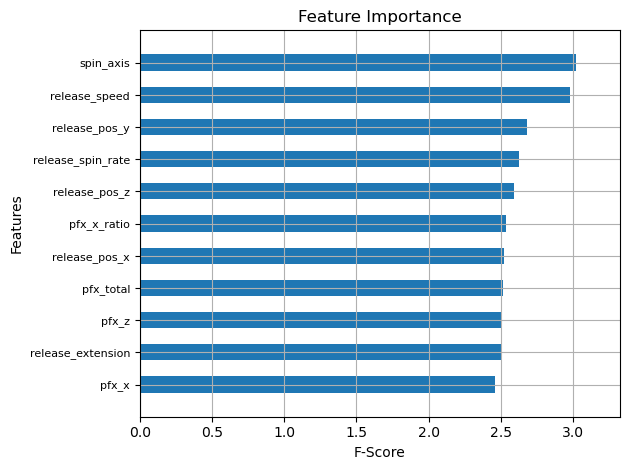

In [40]:
plt.figure(figsize=(10, 50))  # You may adjust this if needed
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)  # You can adjust fontsize if the labels are too crowded
plt.tight_layout()  # Adjust the layout to fit all labels and titles
plt.savefig('feature_importance_bb.png', dpi=300)  # Save with high resolution
plt.show()

In [41]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

spin_axis: 3.021914005279541
release_speed: 2.9814612865448
release_pos_y: 2.6787142753601074
release_spin_rate: 2.6226003170013428
release_pos_z: 2.5892207622528076
pfx_x_ratio: 2.532480001449585
release_pos_x: 2.5179834365844727
pfx_total: 2.51628041267395
pfx_z: 2.5058469772338867
release_extension: 2.500121831893921
pfx_x: 2.458225965499878


In [42]:
print(X.head())

   release_speed  release_pos_x  release_pos_y  release_pos_z  \
0           83.3          -1.69          54.40           6.21   
1           84.0          -1.66          54.33           6.25   
2           88.9          -1.77          54.43           6.15   
3           78.8          -2.14          53.69           6.48   
4           89.3          -1.96          53.74           6.40   

   release_extension  release_spin_rate  spin_axis  pfx_x  pfx_z  pfx_total  \
0                6.1             2894.0       29.0   0.52  -0.56       1.08   
1                6.2                NaN        NaN   0.47  -0.59       1.06   
2                6.1             2570.0       97.0   0.39   0.50       0.89   
3                6.8             2110.0      330.0   0.73  -0.79       1.52   
4                6.8             2314.0      176.0   0.32   1.25       1.57   

   ...  pfx_x_cor_diff_abs  pfx_z_cor  pfx_z_cor_predicted  \
0  ...                 NaN        NaN                  NaN   
1  ...    

In [382]:
# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [383]:
label_mapping = dict(zip(outcome_encoder.classes_, outcome_encoder.transform(outcome_encoder.classes_)))
print(label_mapping)

{'ball': 0, 'double': 1, 'double_play': 2, 'field_out': 3, 'foul': 4, 'home_run': 5, 'single': 6, 'strike': 7, 'strikeout': 8, 'triple': 9, 'walk': 10}


In [384]:
print(linear_weights)

    Unnamed: 0         description  linear_weight
0            0                ball       0.046350
1            1  caught_stealing_2b      -0.246377
2            2              double       0.753249
3            3         double_play      -0.773110
4            4           field_out      -0.217943
5            5                foul      -0.037243
6            6            home_run       1.368162
7            7              single       0.467429
8            8              strike      -0.052630
9            9           strikeout      -0.215231
10          10              triple       1.097815
11          11                walk       0.236323


In [ ]:
# for each outcome columns: mean rv of outcome * outcome probability
# aggregate by pitcher and pitch type
# rank

In [385]:
linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])
print(linear_weights)

    Unnamed: 0  description  linear_weight  outcome
0            0         ball       0.046350        0
2            2       double       0.753249        1
3            3  double_play      -0.773110        2
4            4    field_out      -0.217943        3
5            5         foul      -0.037243        4
6            6     home_run       1.368162        5
7            7       single       0.467429        6
8            8       strike      -0.052630        7
9            9    strikeout      -0.215231        8
10          10       triple       1.097815        9
11          11         walk       0.236323       10


In [386]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# Now perform the weighted sum
df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [387]:
grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 50)

# Group the DataFrame by 'player_name' and 'pitch_type' and sum the 'pitch_quality'
pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# Sort the results by 'pitch_quality' in descending order and take the top 10
top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# Sort the results by 'pitch_quality' in ascending order and take the bottom 10
bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# Print the top 10 and bottom 10
print("Top 10:")
print(top_10)
print("\nBottom 10:")
print(bottom_10)

Top 10:
            player_name pitch_type  pitch_quality
896         Short, Zack         FA       0.038456
208     Coulombe, Danny         SI       0.038009
619         Maile, Luke         FA       0.031131
508       Kelly, Carson         FA       0.029692
100     Bleier, Richard         SI       0.029009
217    Criswell, Cooper         FC       0.024623
906        Small, Ethan         FF       0.023279
966        Suter, Brent         SI       0.019006
138  Bumgarner, Madison         FF       0.016884
367      Gomber, Austin         FF       0.016823

Bottom 10:
            player_name pitch_type  pitch_quality
206     Coulombe, Danny         FC      -0.038908
421       Helsley, Ryan         FF      -0.028559
207     Coulombe, Danny         FF      -0.026334
1015    Valdez, Framber         FC      -0.023499
187     Clase, Emmanuel         FC      -0.023124
70      Bautista, Félix         FF      -0.022618
308        Floro, Dylan         SI      -0.020583
1107         Woo, Bryan       

In [388]:
max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']

mean_stuff = pitch_quality_sum['stuff_plus'].mean()

scaling_factor = 100 / mean_stuff

# Apply the scaling factor
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor

# Adjust the mean to be exactly 100
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# Now sort by the new normalized_quality column and display the results
sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)
sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1
sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)
sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(50)

,player_name,pitch_type,stuff_plus
1,"Coulombe, Danny",FC,194
2,"Helsley, Ryan",FF,168
3,"Coulombe, Danny",FF,162
4,"Valdez, Framber",FC,155
5,"Clase, Emmanuel",FC,154
6,"Bautista, Félix",FF,153
7,"Floro, Dylan",SI,148
8,"Woo, Bryan",FC,145
9,"Estrada, Jeremiah",FF,142
10,"Hill, Tim",SI,141


In [363]:
# Take the top 25 rows from your sorted DataFrame
top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# Plotting as a table and removing axis
fig, ax = plt.subplots(figsize=(6, 8))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',  # Center text in cells
                 colLoc='center')  # Center text in column headers
plt.tight_layout()

# Save the figure as a .png file to the specified path
plt.savefig(r'C:\Users\adam.bloebaum\.vscode\driveline\stuff_plus_v1.png', dpi=300)

plt.close()  # Close the plot to prevent it from displaying in the notebook output
